In [3]:
%load_ext autoreload
%autoreload 2
import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets


import functools

import e3x
import flax.linen as nn
import jax
import jax.numpy as jnp

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)|
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from dcmnet.data import prepare_batches, prepare_datasets

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


In [4]:
gpu4pyscf_data = list(Path("/cluster/pchem-data/meuwly/boittier/home/esps_pyscf/240124_combined_water/").glob("waterdimer*npz"))

In [5]:
gpu4pyscf_data = [_ for _ in gpu4pyscf_data if np.load(_)["R"].shape[0] == 6]
# gpu4pyscf_data

In [6]:
len(gpu4pyscf_data)

7000

In [7]:
np.load(gpu4pyscf_data[0])["esp"].shape

(1529,)

In [8]:
polar = np.concatenate([np.load(gpu4pyscf_data[0])["polar"], np.load(gpu4pyscf_data[0])["polar"]])
polar[None]

array([[[ 9.45813137,  0.23264394, -0.33217304],
        [ 0.23264394,  7.9669174 , -0.33703803],
        [-0.33217304, -0.33703803,  7.12441946],
        [ 9.45813137,  0.23264394, -0.33217304],
        [ 0.23264394,  7.9669174 , -0.33703803],
        [-0.33217304, -0.33703803,  7.12441946]]])

In [9]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
149026//1529

97

In [10]:
train_data, valid_data = prepare_datasets(data_key, 6950, 50, gpu4pyscf_data[:7000], clip_esp=True, natoms=6)

shape (7000, 6, 3)
dipole.shape (7000, 3)
polar (7000, 3, 3)
R (1, 7000, 6, 3)
(7000, 6, 3)
['R', 'Z', 'esp', 'dipole', 'polar', 'esp_grid', 'quadrupole']
7000
0 R 7000 (7000, 6, 3)
1 Z 7000 (7000, 6)
2 esp 7000 (7000, 1000)
3 dipole 7000 (7000, 3)
4 polar 7000 (7000, 3, 3)
5 esp_grid 7000 (7000, 1000, 3)
6 quadrupole 7000 (7000, 3, 3)


In [11]:
len(train_data["R"])

6950

In [12]:
train_batches = prepare_batches(data_key, train_data, 1, data_keys=["Z", "R", "polar"], num_atoms=6)

In [13]:
valid_batches = prepare_batches(data_key, valid_data, 1, data_keys=["Z", "R", "polar"], num_atoms=6)

In [33]:
class POLAR(nn.Module):
    features: int = 32
    max_degree: int = 2
    num_iterations: int = 3
    num_basis_functions: int = 8
    cutoff: float = 5.0
    max_atomic_number: int = 17
    n_dcm: int = 4
    include_pseudotensors: bool = False
    def mono(
        self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size
    ):
        # 1. Calculate displacement vectors.
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

        # 2. Expand displacement vectors in basis functions.
        basis = e3x.nn.basis(
            # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff),
        )

        x = e3x.nn.Embed(
            num_embeddings=self.max_atomic_number + 1, features=self.features
        )(atomic_numbers)

        # 4. Perform iterations (message-passing + atom-wise refinement).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Final iteration.
                y = e3x.nn.MessagePass(
                    max_degree=self.max_degree, include_pseudotensors=False
                )(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            else:
                y = e3x.nn.MessagePass(include_pseudotensors=self.include_pseudotensors)(
                    x, basis, dst_idx=dst_idx, src_idx=src_idx
                )
            y = e3x.nn.add(x, y)
            # Atom-wise refinement MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features)(y)
            # Residual connection.
            x = e3x.nn.add(x, y)

        x = e3x.nn.TensorDense(
            features=self.features,
            max_degree=2,
            include_pseudotensors=False,
        )(x)
        
        # print(x.shape)

        x = jnp.sum(x[..., 0, :, 0], axis=-2)  # Shape (..., (max_degree+1)**2).
        # print(x.shape)
        # 4. Convert output irreps to 3x3 matrix and return.
        cg = e3x.so3.clebsch_gordan(max_degree1=1, max_degree2=1, max_degree3=2)  # Shape (4, 4, 9).
        y = jnp.einsum('...l,nml->...nm', x, cg[1:, 1:, :])  # Shape (..., 3, 3).
        

        return y

    @nn.compact
    def __call__(
        self,
        atomic_numbers,
        positions,
        dst_idx,
        src_idx,
        batch_segments=None,
        batch_size=None,
    ):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1

        return self.mono(
            atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size
        )

In [34]:
model = POLAR()

In [35]:
model

POLAR(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 8
    cutoff = 5.0
    max_atomic_number = 17
    n_dcm = 4
    include_pseudotensors = False
)

In [17]:
import functools

import jax
import jax.numpy as jnp
import numpy as np
import optax
from jax.random import randint

from dcmnet.electrostatics import batched_electrostatic_potential, calc_esp
from dcmnet.modules import NATOMS
from dcmnet.utils import reshape_dipole


def polar_loss(a, b):
    l2_loss = optax.l2_loss(a, b.squeeze()) * 2
    loss = np.mean(l2_loss) ** 0.5
    return loss


In [20]:
import functools
import pickle

import e3x
import jax
import jax.numpy as jnp
import optax
from dcmnet.loss import dipo_esp_mono_loss
from dcmnet.data import prepare_batches, prepare_datasets

import jax
import jax.numpy as jnp
import optax
from collections import deque
from typing import Dict, Optional, Literal


def clip_grads_by_global_norm(grads, max_norm):
    """
    Clips gradients by their global norm.
    
    Args:
    - grads: The gradients to clip.
    - max_norm: The maximum allowed global norm.
    
    Returns:
    - clipped_grads: The gradients after global norm clipping.
    """
    # Compute the global L2 norm of the gradients
    global_norm = jnp.sqrt(sum([jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)]))
    
    # Compute the clipping factor (ratio of max_norm to global norm)
    clip_factor = jnp.minimum(1.0, max_norm / (global_norm + 1e-6))  # Add a small value for numerical stability
    
    # Scale all gradients by the clip_factor if needed
    clipped_grads = jax.tree_map(lambda g: g * clip_factor, grads)
    
    return clipped_grads


import optax
import jax.numpy as jnp

def create_adam_optimizer_with_exponential_decay(
    initial_lr, final_lr, transition_steps, total_steps
):
    """
    Create an Adam optimizer with an exponentially decaying learning rate.
    
    Args:
    - initial_lr: Initial learning rate (e.g., 5e-4).
    - final_lr: Final learning rate (e.g., 1e-5).
    - transition_steps: How many steps before the learning rate starts decaying.
    - total_steps: The total number of training steps.
    
    Returns:
    - An Adam optimizer with exponential decay.
    """
    # Calculate the decay rate needed to go from initial_lr to final_lr over total_steps
    # decay_rate = (final_lr / initial_lr) ** (1 / total_steps)
    
    # # Learning rate schedule with exponential decay
    # lr_schedule = optax.exponential_decay(
    #     init_value=initial_lr,
    #     transition_steps=transition_steps,
    #     decay_rate=decay_rate,
    #     end_value=final_lr,  # Set the final value to explicitly stop at final_lr
    #     staircase=False  # Smooth decay, set True if you want step-wise decay
    # )

    num_cycles = 10
    lr_schedule = optax.join_schedules(schedules=
                                        [optax.cosine_onecycle_schedule(
        peak_value=0.0005 - 0.00005*i,
        transition_steps=500,
        div_factor=1.1,
        final_div_factor=2
    ) for i in range(num_cycles)], 
                                       boundaries=jnp.cumsum(jnp.array([500] * num_cycles)))


    # lr_schedule = optax.cosine_onecycle_schedule(
    #     peak_value=0.001,
    #     transition_steps=3000,
    #     div_factor=2,
    #     final_div_factor=2
    # )

    # Adam optimizer with the learning rate schedule
    # optimizer = optax.adamw(learning_rate=lr_schedule)
    optimizer = optax.adamw(learning_rate=0.001)

    # optimizer = optax.adam(learning_rate=0.00001)
    # optimizer = optax.amsgrad(learning_rate=lr_schedule)
    return optimizer


def initialize_ema_params(params):
    """
    Initialize EMA parameters. Typically initialized to the same values as the initial model parameters.
    
    Args:
    - params: Initial model parameters.
    
    Returns:
    - A copy of the parameters for EMA tracking.
    """
    return jax.tree_util.tree_map(lambda p: p, params)  # Creates a copy of the initial parameters

def update_ema_params(ema_params, new_params, decay):
    """
    Update EMA parameters using exponential moving average.
    
    Args:
    - ema_params: Current EMA parameters.
    - new_params: Updated parameters from the current training step.
    - decay: Decay factor for EMA (e.g., 0.999).
    
    Returns:
    - Updated EMA parameters.
    """
    return jax.tree_util.tree_map(
        lambda ema, new: decay * ema + (1.0 - decay) * new, ema_params, new_params
    )



@functools.partial(
    jax.jit,
    static_argnames=("model_apply", "optimizer_update", "batch_size"),
)
def train_step(
    model_apply, optimizer_update, batch, batch_size, opt_state, params,
     clip_norm=2.0
):
    def loss_fn(params):
        polar = model_apply(
            params,
            atomic_numbers=batch["Z"],
            positions=batch["R"],
            dst_idx=batch["dst_idx"],
            src_idx=batch["src_idx"],
            batch_segments=batch["batch_segments"],
        )
        loss = polar_loss(
            a=polar,
            b=batch["polar"],
            # batch_size=batch_size,
        )
        return loss, polar

    (loss, polar), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # Clip gradients by their global norm
    clipped_grads = clip_grads_by_global_norm(grad, clip_norm)
    updates, opt_state = optimizer_update(clipped_grads, opt_state, params)
    # updates, opt_state = optimizer_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss


@functools.partial(
    jax.jit, static_argnames=("model_apply", "batch_size")
)
def eval_step(model_apply, batch, batch_size, params):
    polar = model_apply(
        params,
        atomic_numbers=batch["Z"],
        positions=batch["R"],
        dst_idx=batch["dst_idx"],
        src_idx=batch["src_idx"],
        batch_segments=batch["batch_segments"],
        batch_size=batch_size,
    )
    loss = polar_loss(
        a=polar,
        b=batch["polar"],
        # batch_size=batch_size,
    )
    return loss


def train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    restart_params=None,
):
    best = 10**7
    # Initialize model parameters and optimizer state.
    key, init_key = jax.random.split(key)

    # optimizer = optax.adam(learning_rate)
    # Example parameters for the optimizer
    initial_lr = learning_rate         
    final_lr = 1e-6           # 1 * 10^(-5)
    transition_steps = 10   # Number of steps before decaying

    # Create the Adam optimizer with the exponential decay schedule
    optimizer = create_adam_optimizer_with_exponential_decay(
        initial_lr=initial_lr,
        final_lr=final_lr,
        transition_steps=transition_steps,
        total_steps=num_epochs
    )
    
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(train_data["Z"][0]))
    params = model.init(
        init_key,
        atomic_numbers=train_data["Z"][0],
        positions=train_data["R"][0],
        dst_idx=dst_idx,
        src_idx=src_idx,
    )
    if restart_params is not None:
        params = restart_params

    opt_state = optimizer.init(params)
    # Initialize EMA parameters (a copy of the initial parameters)
    # ema_params = initialize_ema_params(params)
    print("Preparing batches")
    print("..................")
    # Batches for the validation set need to be prepared only once.
    key, shuffle_key = jax.random.split(key)
    valid_batches = prepare_batches(shuffle_key, valid_data, batch_size, data_keys=["Z", "R", "polar"], num_atoms=6)

    # Train for 'num_epochs' epochs.
    for epoch in range(1, num_epochs + 1):
        # Prepare batches.
        key, shuffle_key = jax.random.split(key)
        train_batches = prepare_batches(shuffle_key, train_data, batch_size, data_keys=["Z", "R", "polar"], num_atoms=6)
        # Loop over train batches.
        train_loss = 0.0
        for i, batch in enumerate(train_batches):
            params, opt_state, loss = train_step(
                model_apply=model.apply,
                optimizer_update=optimizer.update,
                batch=batch,
                batch_size=batch_size,
                opt_state=opt_state,
                params=params,
            )
            train_loss += (loss - train_loss) / (i + 1)
            
        del train_batches
        
        # Evaluate on validation set.
        valid_loss = 0.0
        for i, batch in enumerate(valid_batches):
            loss = eval_step(
                model_apply=model.apply,
                batch=batch,
                batch_size=batch_size,
                params=params,
            )
            valid_loss += (loss - valid_loss) / (i + 1)



        if valid_loss < best:
            best = valid_loss
            # open a file, where you want to store the data
            if writer is not None:
                with open(f"{writer.logdir}/best_{esp_w}_params.pkl", "wb") as file:
                    pickle.dump(params, file)

        
        if writer is not None:
            # Log metrics
            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Loss/valid", valid_loss, epoch)
            writer.add_scalar("Loss/bestValid", best, epoch)
        else:
            print(epoch, train_loss, valid_loss)

    # Return final model parameters.
    return params, valid_loss


In [21]:
params, valid_loss = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    10,
    1, 
    1,
    None
)

(6, 1, 9, 32)
(9,)
Preparing batches
..................
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
1 0.9009624 0.4228145
2 0.5184702 0.2601193
3 0.42926723 0.20060758
4 0.38055396 0.29680234
5 0.3585644 0.22687757
6 0.33669132 0.28354907
7 0.3153582 0.23334055
8 0.30185112 0.15866816
9 0.2847859 0.239293
10 0.2821573 0.12878151


In [36]:
params, valid_loss = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    100,
    1, 
    1,
    None,
    restart_params=params
)

Preparing batches
..................
1 0.1385533 0.09179752
2 0.13440907 0.14232995
3 0.13633397 0.07884719
4 0.13872196 0.09112835
5 0.13249037 0.10141468
6 0.13351335 0.11559421
7 0.13603148 0.09993532
8 0.13303494 0.088859364
9 0.13250008 0.07407545
10 0.13262749 0.0784287
11 0.13014624 0.08754039
12 0.13184062 0.064966865
13 0.12834586 0.16045448
14 0.12951301 0.06551404
15 0.12993671 0.13463631
16 0.1291849 0.081718296
17 0.12802319 0.13940603
18 0.13003415 0.11140439
19 0.13243458 0.06204861
20 0.12916498 0.07088022
21 0.12570298 0.057264984
22 0.12892397 0.06631115
23 0.12771139 0.16505885
24 0.12746038 0.09850912
25 0.12673919 0.07773149
26 0.12783863 0.102469385
27 0.12653394 0.06492879
28 0.12866287 0.066565074
29 0.12427846 0.09065219
30 0.12600777 0.057936396
31 0.12638582 0.09454247
32 0.12323008 0.10248035
33 0.12544607 0.10761847
34 0.12753548 0.09352155
35 0.1281981 0.14022993
36 0.12706308 0.09444433
37 0.124713905 0.08055781
38 0.1239657 0.08919298
39 0.12340562 0.069

In [25]:
valid_batches = prepare_batches(data_key, valid_data, 1, data_keys=["Z", "R", "polar"], num_atoms=6)

In [26]:
a = []
b = []

for i, batch in enumerate(valid_batches):
    polar = model.apply(
        params,
        atomic_numbers=batch["Z"],
        positions=batch["R"],
        dst_idx=batch["dst_idx"],
        src_idx=batch["src_idx"],
        batch_segments=batch["batch_segments"],
        batch_size=1,
    )
    a.append(polar)
    b.append(batch["polar"])

    loss = polar_loss(polar, batch["polar"])
    
    if loss > 1:    
        print(i, loss)

(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
33 1.1491177
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)
(6, 1, 9, 32)
(9,)


In [27]:
a = np.concat(a).flatten()
b = np.concat(b).flatten()

In [31]:
np.mean(abs(a -b))

np.float64(0.062389344209055925)

In [32]:
np.mean(((a - b)**2))**0.5

np.float64(0.1840677629012504)

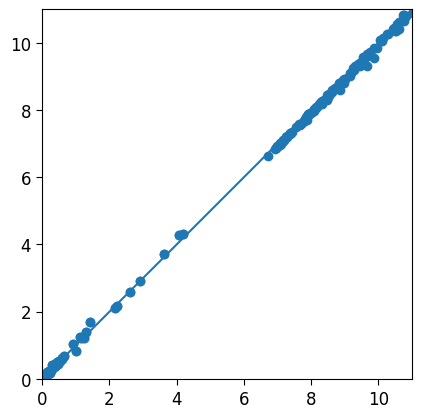

In [28]:
plt.scatter(a, b)
ax = plt.gca()
ax.set_aspect("equal")
ax.set_xlim(0, 11)
ax.set_ylim(0, 11)
ax.plot([0,11],[0,11])

In [235]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol



In [236]:
# Initialize atoms object and attach calculator.
atoms = ase.Atoms(valid_batches[4]['Z'], valid_batches[4]['R'])
# atoms.set_calculator(MessagePassingCalculator())

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [237]:
# Initialize atoms object and attach calculator.
atoms = ase.Atoms(valid_batches[5]['Z'], valid_batches[5]['R'])
# atoms.set_calculator(MessagePassingCalculator())

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.